<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import sys
sys.path.append('C:/users/Jesse/Python/gEconpy/')

import gEconpy as ge
import gEconpy.plotting as gp
import sympy as sp
from gEconpy.shared.utilities import eq_to_ss
import numpy as np

def make_python_func(args, cse_dict, expr):
    printer = sp.printing.numpy.NumPyPrinter()
    code = 'def f_x(' + ','.join(args) + '):\n'
    code += '\n'.join([f'\t{x} = {y}' for x, y in cse_dict])
    code += '\n\n'
    code += '\tout = np.array([' + "\t\t".join([printer.doprint(x) + ',\n' for x in expr]) + '\t])'
    code += '\n\n'
    code += '\treturn out'
    
    code = code.replace('numpy', 'np')
    exec(code)
    f = locals()['f_x']
    return f

In [165]:
mod = ge.gEconModel('../gcn_files/rbc_2_region.gcn')

Model Building Complete.
Found:
	42 equations
	42 variables
	The following "variables" were defined as constants and have been substituted away:
		P_t
	2 stochastic shocks
		 0 / 2 has a defined prior. 
	19 parameters
		 0 / 19 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [157]:
globals().update({x.base_name:x for x in mod.variables})
globals().update({'lam': mod.variables[31]})
globals().update({x.name:x for x in mod.free_param_dict.to_sympy()})

In [158]:
bc = mod.system_equations[0]

In [159]:
for i, x in enumerate(mod.system_equations):
    print(i, x)

0 Div_A_i_t + Div_B_i_t - omega_t*(C_A_t + I_A_t) + omega_t*(Div_A_t + K_A_t-1*r_A_t + L_A_t*w_A_t) - (1 - omega_t)*(C_B_t + I_B_t) + (1 - omega_t)*(Div_B_t + K_B_t-1*r_B_t + L_B_t*w_B_t)
1 I_A_t - K_A_t + K_A_t-1*(1 - delta)
2 I_B_t - K_B_t + K_B_t-1*(1 - delta)
3 beta*U_t+1 - U_t + omega_t*(C_A_t**(1 - sigma_C)/(1 - sigma_C) - L_A_t**(sigma_L + 1)/(sigma_L + 1)) + (1 - omega_t)*(C_B_t**(1 - sigma_C)/(1 - sigma_C) - L_B_t**(sigma_L + 1)/(sigma_L + 1))
4 -lambda_t*omega_t + omega_t/C_A_t**sigma_C
5 -lambda_t*(1 - omega_t) + (1 - omega_t)/C_B_t**sigma_C
6 -L_A_t**sigma_L*omega_t + lambda_t*omega_t*w_A_t
7 L_B_t**sigma_L*(omega_t - 1) + lambda_t*w_B_t*(1 - omega_t)
8 -lambda_t*omega_t + q_A_t
9 -lambda_t*(1 - omega_t) + q_B_t
10 beta*(lambda_t+1*omega_t+1*r_A_t+1 - q_A_t+1*(delta - 1)) - q_A_t
11 beta*(lambda_t+1*r_B_t+1*(1 - omega_t+1) - q_B_t+1*(delta - 1)) - q_B_t
12 C_A_t**(1 - sigma_C)/(1 - sigma_C) - C_B_t**(1 - sigma_C)/(1 - sigma_C) - L_A_t**(sigma_L + 1)/(sigma_L + 1) + L_B_t**(

In [160]:
div_A_solved  = sp.solve(mod.system_equations[13], Div_A)[0]
div_B_solved  = sp.solve(mod.system_equations[18], Div_B)[0]
div_Ai_solved = sp.solve(mod.system_equations[24], Div_A_i)[0]
div_Bi_solved = sp.solve(mod.system_equations[31], Div_B_i)[0]

TC_A_solved = sp.solve(mod.system_equations[15], TC_A)[0]
TC_B_solved = sp.solve(mod.system_equations[20], TC_B)[0]
TC_A_i_solved = sp.solve(mod.system_equations[27], TC_A_i)[0]
TC_B_i_solved = sp.solve(mod.system_equations[34], TC_B_i)[0]

Y_A_i_solved = sp.solve(mod.system_equations[25], Y_A_i)[0]
Y_B_i_solved = sp.solve(mod.system_equations[32], Y_B_i)[0]


In [161]:
(bc.subs({Div_A:div_A_solved, Div_B:div_B_solved, Div_A_i:div_Ai_solved, Div_B_i:div_Bi_solved})
   .subs({TC_A_i:TC_A_i_solved, TC_B_i:TC_B_i_solved})
   .subs({TC_A:TC_A_solved, TC_B:TC_B_solved})
   .subs({Y_A_i:Y_A_i_solved, Y_B_i:Y_B_i_solved})
     .simplify()
#     .expand()
#    .collect(P_A_i * Y_BA)
#    .collect(P_B_i * Y_AB)
   .collect(P_A).collect(P_B).collect(P_B_i).collect(omega).collect(-C_B - I_B + Y_B).collect(-C_A - I_A + Y_A)
   
)

-C_B_t - I_B_t + Y_B_t + omega_t*(-C_A_t + C_B_t - I_A_t + I_B_t + Y_A_t - Y_B_t)

In [216]:
mod.free_param_dict.update({'psi_1':2, 'psi_2':2, 'psi_A':0.1, 'psi_B':0.3, 'psi_Y':0.1})
mod.steady_state()

Steady state found! Sum of squared residuals is 1.5267547471016221e-21


In [217]:
mod.solve_model(solver='cycle_reduction', not_loglin_variable=[x.base_name for x in mod.variables])

LinAlgError: Array must not contain infs or NaNs.

In [214]:
import pandas as pd

irf = mod.impulse_response_function(simulation_length=40, shock_size=0.1)
ss_vals = pd.Series(mod.steady_state_dict, name='Variables')
irf = irf + ss_vals.values[:, None]

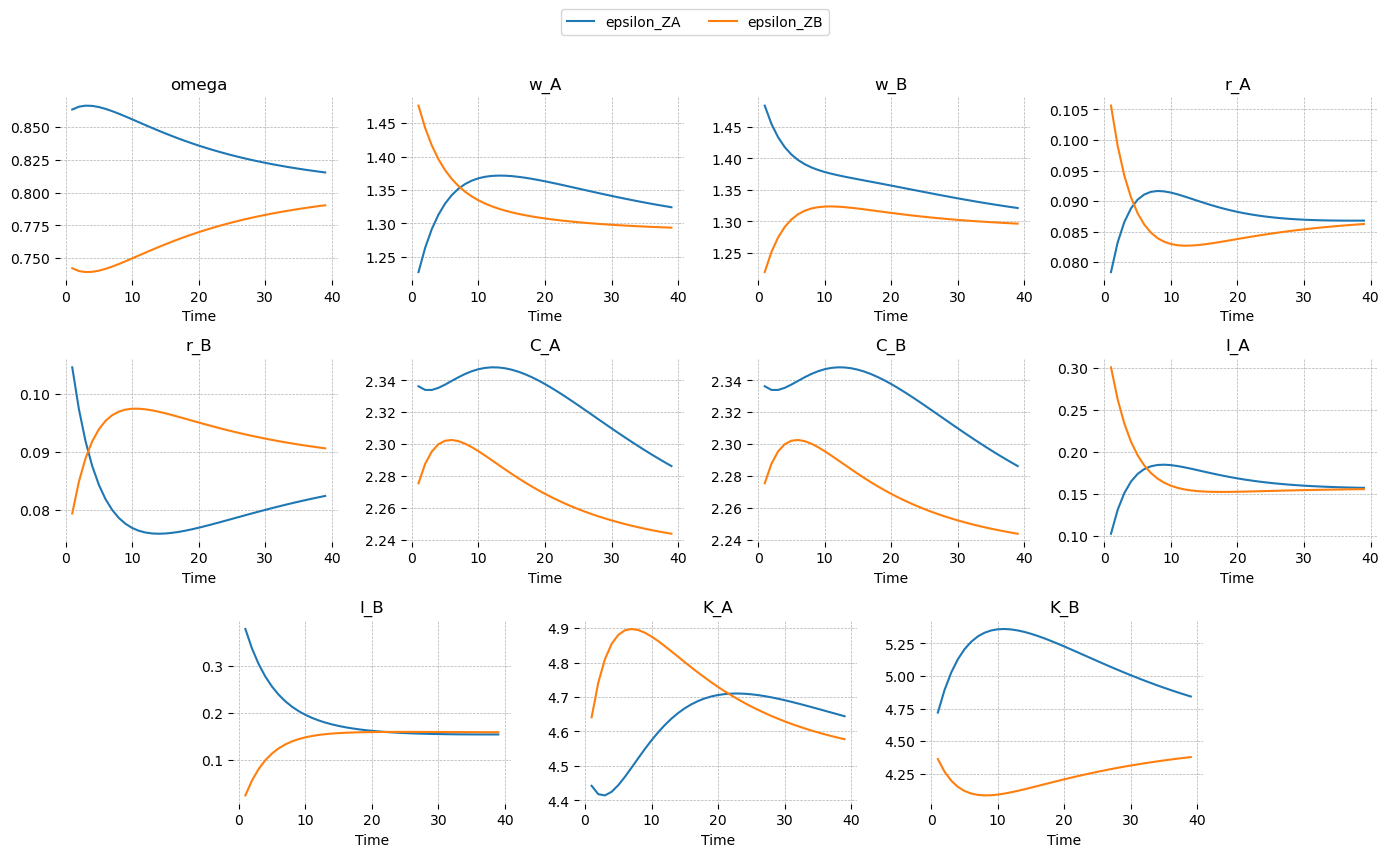

In [215]:
gp.plot_irf(irf.iloc[:, 2:], vars_to_plot=['omega', 'w_A', 'w_B', 'r_A', 'r_B', 'C_A', 'C_B', 'I_A', 'I_B', 'K_A', 'K_B'], legend=True, figsize=(14,8));

In [219]:
print(ge.make_mod_file(mod))

var C_A, C_B, Div_A, Div_A_i, Div_B, Div_B_i, Div_Y;
var I_A, I_B, K_A, K_B, L_A, L_B, P_A, P_A_i, P_B, P_B_i;
var TC_A, TC_A_i, TC_B, TC_B_i, TC_Y, U, Y, Y_A, Y_AA;
var Y_AB, Y_A_i, Y_B, Y_BA, Y_BB, Y_B_i, Z_A, Z_B, q_A;
var q_B, r_A, r_B, var_lambda, var_omega, w_A, w_B;
varexo epsilon_ZA, epsilon_ZB;

parameters alpha_A, alpha_Ai, alpha_B, alpha_Bi, alpha_C;
parameters alpha_Y, param_beta, param_delta, psi_1;
parameters psi_2, psi_A, psi_B, psi_C, psi_Y, psi_omega;
parameters rho_ZA, rho_ZB, sigma_C, sigma_L;

alpha_A = 0.5;
alpha_Ai = 0.33;
alpha_B = 0.5;
alpha_Bi = 0.33;
alpha_C = 0.5;
alpha_Y = 0.5;
param_beta = 0.95;
param_delta = 0.035;
psi_1 = 2;
psi_2 = 2;
psi_A = 0.1;
psi_B = 0.3;
psi_C = 0.6;
psi_Y = 0.1;
psi_omega = 0.5;
rho_ZA = 0.95;
rho_ZB = 0.95;
sigma_C = 1.5;
sigma_L = 2.0;

model;
Div_A_i + Div_B_i - P_A * var_omega *(C_A + I_A) - P_B *(1 - var_omega) *(C_B + I_B) + var_omega *(Div_A + K_A(-1) * r_A + L_A * w_A) +(1 - var_omega) *(Div_B + K_B(-1) * r_B + L_B * w_B) 